# Notebook exploration et traitement
Ce notebook se dédie à configurer l'environnement mlflow. Prépare l'echantillon. Nettoie les parties textes des titres et des messages. Rassemble les tags les plus récurrents sous forme de liste de 20 tags.

Il a une partie ou le texte est réduit en Bag of Word. 
Réduit en principaux composants, en vecteur avec SVD. Le résultat est enregistré dans mlflow.

Une deuxieme partie ou les textes sont transformés en Word2vec. Le resultat est enregistré dans mlflow pour un usage ultérieur.

Une troisieme partie test avec un model pré-entrainé avec Universal Sentence Encoder.
Enregistré dans mlflow.


## Préparation des données

### Importation des dépendances et configuration

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
import mlflow
import mlflow.keras
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np
import tensorflow_hub as hub
import os
import tensorflow as tf
import joblib
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import logging

# Charge les variables d'environnement et configure MLflow
load_dotenv()
tracking_uri = "https://mlflowp51-975919512217.us-central1.run.app"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Text_Processing_Experiment")

print("Tracking URI:", mlflow.get_tracking_uri())

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "f8bc1d91ca98.json"


2024/10/13 00:14:03 INFO mlflow.tracking.fluent: Experiment with name 'Text_Processing_Experiment' does not exist. Creating a new experiment.


Tracking URI: https://mlflowp51-975919512217.us-central1.run.app


### Importation des données

In [2]:
df = pd.read_csv('db/questions_db.csv')
print(df.head())

# Réduit l'échantillon
df = df.sample(frac=0.2, random_state=42)
df.info()





                                               Title  \
0  How do I solve "error: externally-managed-envi...   
1  Why does VSCode give me an error when trying t...   
2  Error "'DataFrame' object has no attribute 'ap...   
3  pip install -r requirements.txt is failing: "T...   
4  OpenAI API error 429: "You exceeded your curre...   

                                                Body  \
0  <p>When I run <code>pip install xyz</code> on ...   
1  <p>I created a temporary file in VSCode, I hit...   
2  <p>I am trying to append a dictionary to a Dat...   
3  <p>Command:</p>\n<pre class="lang-none prettyp...   
4  <p>I'm making a Python script to use OpenAI vi...   

                                                Tags        Id  Score  \
0              <python><error-handling><pip><debian>  75608323    620   
1            <visual-studio-code><vscode-extensions>  78549413     -1   
2        <python><pandas><dataframe><attributeerror>  75956209    293   
3                                 

### Lemmatization, tokenisation, stopwords

In [3]:
# Prétraitement des données (nettoyage)
df_cleaned = df.copy()  # Sauvegarde de la version nettoyée de df

# Lemmatizer et stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Nettoie les colonnes 'Title' et 'Body'
def clean_text(text):
    if isinstance(text, str):
        # Supprime les balises HTML et leur contenu
        text = re.sub(r'<[^>]*>', '', text)  
        
        # Supprime les caractères spéciaux qui ne sont pas des lettres ou des espaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize les mots et applique lemmatization
        words = text.split()
        words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words] 
        
        # Supprime les mots de 2 lettres ou moins
        return ' '.join([word for word in words if len(word) > 2])
    return text

# Applique le nettoyage avec lemmatizer
df_cleaned['Cleaned_Title'] = df_cleaned['Title'].apply(clean_text)
df_cleaned['Cleaned_Body'] = df_cleaned['Body'].apply(clean_text)

# Ajout des nouvelles features
def add_features(df):
    # Ajout des nouvelles features
    df_cleaned['Title_length'] = df_cleaned['Title'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df_cleaned['Body_word_count'] = df_cleaned['Body'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df_cleaned['Tag_count'] = df_cleaned['Tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    return df

df_cleaned = add_features(df_cleaned)

# Suivi MLflow pour nettoyage de texte et extraction de features
with mlflow.start_run(run_name="Text Cleaning and Features"):
    mlflow.log_param("num_rows", len(df_cleaned))
    mlflow.log_param("num_columns", df_cleaned.shape[1])

    # Log d'un échantillon des données nettoyées
    sample_cleaned = df_cleaned[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']]
    sample_cleaned.to_csv("db/cleaned_data_sample.csv", index=False)
    mlflow.log_artifact("cleaned_data_sample.csv")
    
mlflow.end_run()
print(sample_cleaned['Cleaned_Body'].head(10))


2024/10/13 00:14:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run Text Cleaning and Features at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/080e84da531346dd805ea6f8511ac6ab.
2024/10/13 00:14:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


33553    pretty good experience using aws want use stor...
9427     starting developing xcode tried hello world ru...
199      trying use gensim running import gensim raise ...
12447    following cloud run documentation httpscloudgo...
39489    basically code convert csv file json send requ...
42724    following code snippet try create one action c...
10822    looked everywhere couldnt find documentation c...
49498    building first app capacitor svelte app going ...
4144     styled inputtypedate ltdiv classquotfieldquotg...
36958    validating data model using data annotation ne...
Name: Cleaned_Body, dtype: object


In [4]:
# Liste des tags
def process_tags(tags):
    if isinstance(tags, str):
        return tags.strip('<>').split('><')
    else:
        return []

df_cleaned['Tags'] = df_cleaned['Tags'].apply(process_tags)



### Extraction des 20 tags les plus fréquents

Nombre total de tags extraits: 34472
Top 20 tags sélectionnés: ['python', 'reactjs', 'javascript', 'java', 'android', 'next.js', 'typescript', 'c#', 'node.js', 'spring-boot', 'flutter', 'docker', 'angular', 'azure', 'react-native', 'amazon-web-services', 'ios', 'python-3.x', 'spring', 'visual-studio-code']
<class 'pandas.core.frame.DataFrame'>
Index: 6571 entries, 33553 to 5857
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            6571 non-null   object
 1   Body             6571 non-null   object
 2   Tags             6571 non-null   object
 3   Id               6571 non-null   int64 
 4   Score            6571 non-null   int64 
 5   ViewCount        6571 non-null   int64 
 6   AnswerCount      6571 non-null   int64 
 7   CreationDate     6571 non-null   object
 8   Cleaned_Title    6571 non-null   object
 9   Cleaned_Body     6571 non-null   object
 10  Title_length     6571 non-null   int64 
 

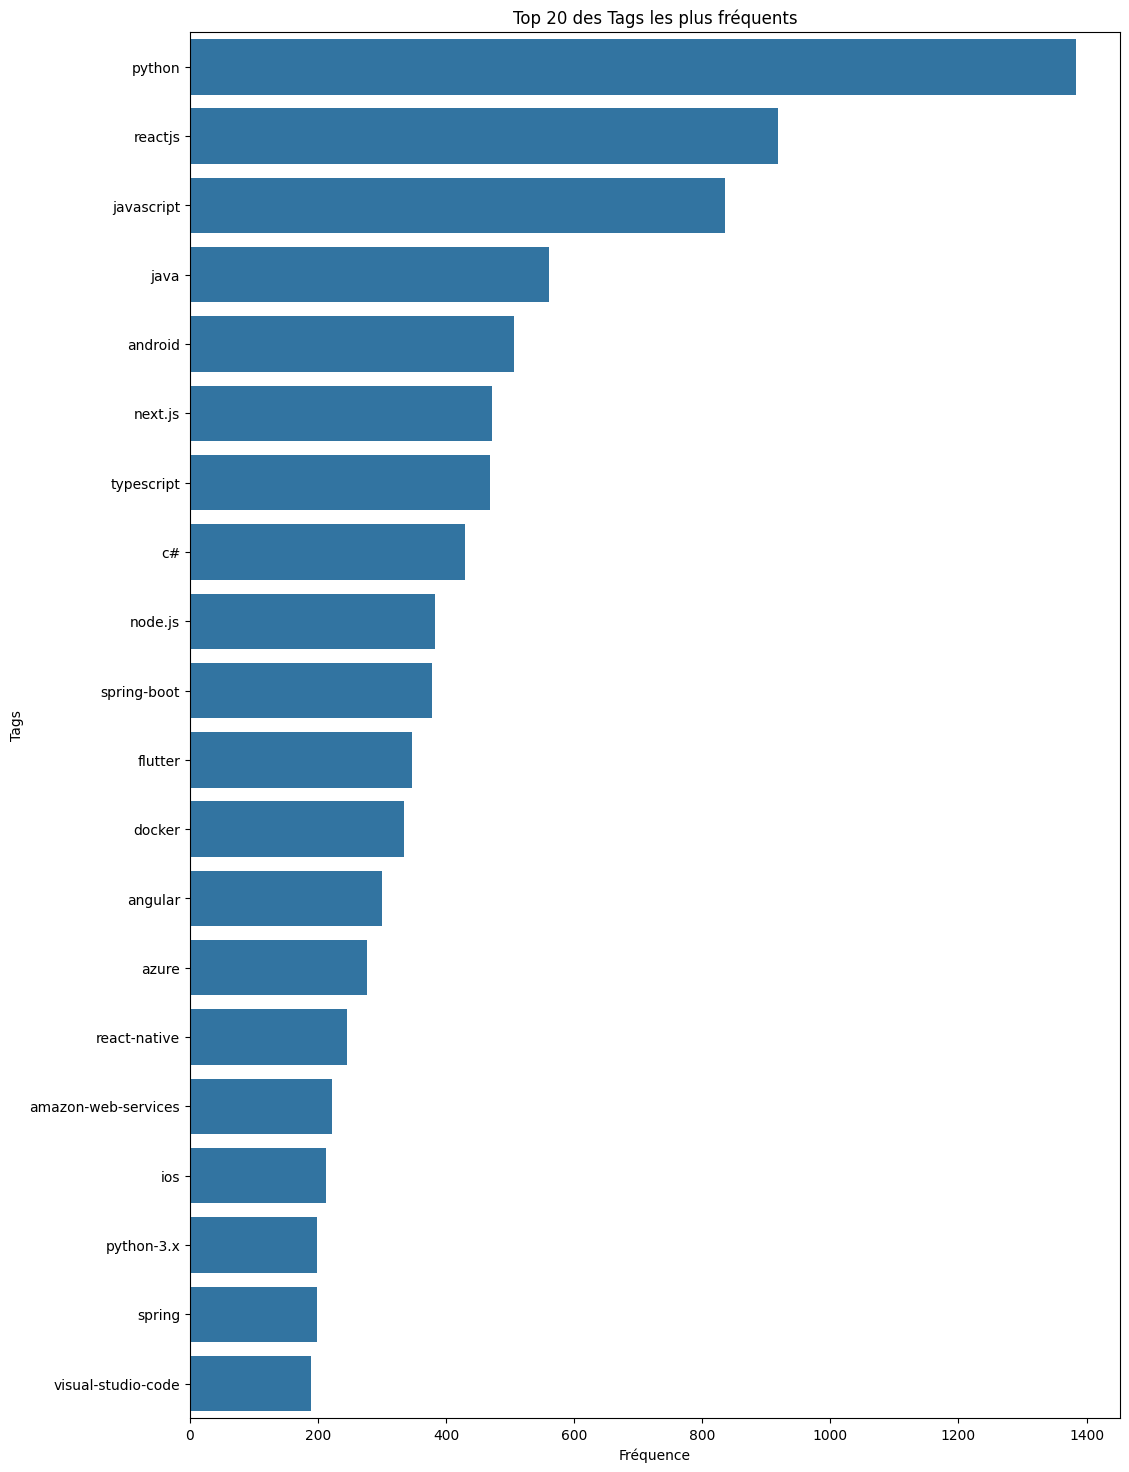

In [5]:
# Extraction des 20 tags les plus fréquents
all_tags = [tag for tags in df_cleaned['Tags'] for tag in tags]

if all_tags:
    print(f"Nombre total de tags extraits: {len(all_tags)}")
else:
    print("Erreur : Aucun tag n'a été extrait")

# Sélection des 20 tags les plus fréquents
tag_counts = pd.Series(all_tags).value_counts().head(20)
top_tags = list(tag_counts.index)

# Filtrage des questions avec ces 20 tags
df_cleaned['Filtered_Tags'] = df_cleaned['Tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])
df_cleaned = df_cleaned[df_cleaned['Filtered_Tags'].apply(lambda x: len(x) > 0)]  # Garder uniquement les questions qui ont des tags valides

print(f"Top 20 tags sélectionnés: {top_tags}")
df_cleaned.info()

print(top_tags)
plt.figure(figsize=(12, 18))
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title('Top 20 des Tags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Tags')
plt.show()


### Analyse Bivariée

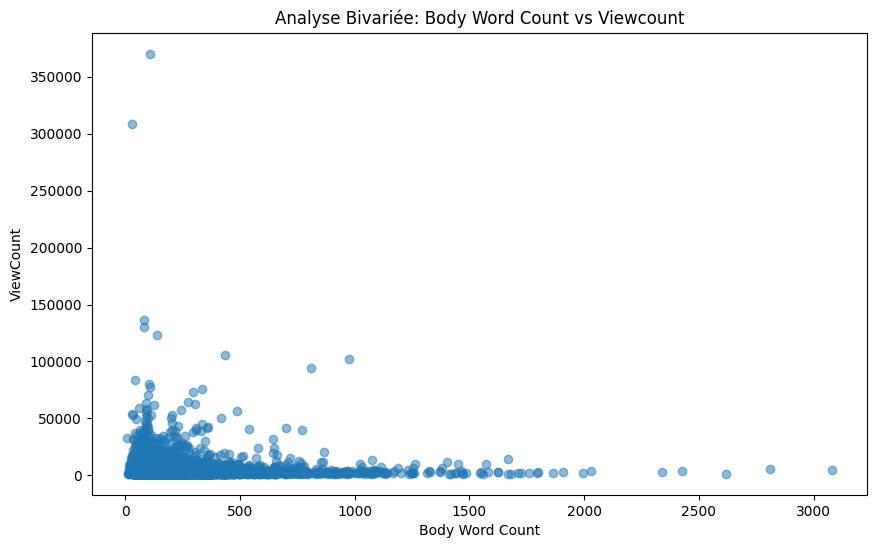

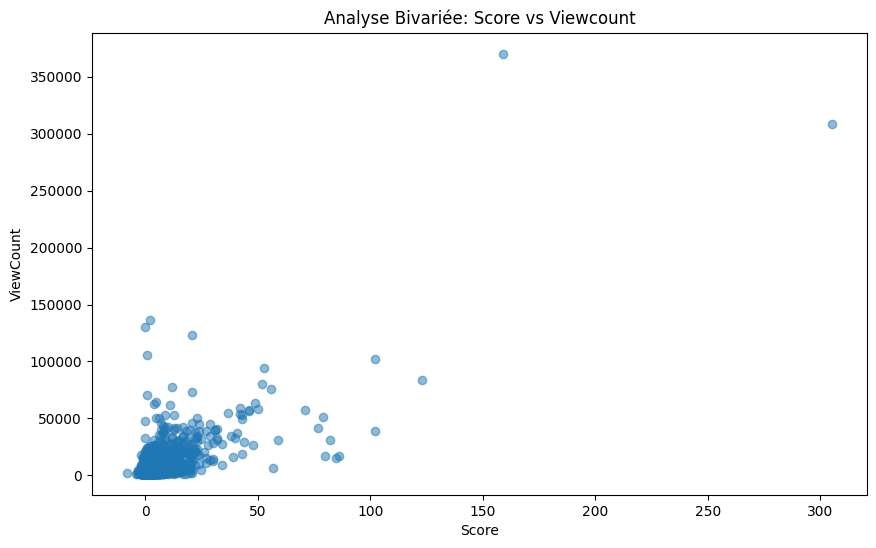

In [6]:

# Scatter plot upour voir le rapport entre la longueur des mots et les vues
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Body_word_count'], df_cleaned['ViewCount'], alpha=0.5)

plt.title('Analyse Bivariée: Body Word Count vs Viewcount')
plt.xlabel('Body Word Count')
plt.ylabel('ViewCount')

# Show plot
plt.show()



# Scatter plot upour voir le rapport entre les scores et les vues
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Score'], df_cleaned['ViewCount'], alpha=0.5)

plt.title('Analyse Bivariée: Score vs Viewcount')
plt.xlabel('Score')
plt.ylabel('ViewCount')

# Show plot
plt.show()




## Transformation des données pour leur traitement dans les modèles de machine learning
Bag of Words, réduction de dimmensions, Essaie avec le modèle Word2Vec et Use Sentence Encoder

In [7]:
# Transforme la presence des tags en 1 et leur absence en 0, permet d'avoir une approche binaire
# ajouté ici pour l'avoir à disposition de manière globale
mlb = MultiLabelBinarizer(classes=top_tags)
y = mlb.fit_transform(df_cleaned['Filtered_Tags'])

### Bag of Words et SVD
Prépare les données, pour les exporter en artefacts pour l'entrainement du modèle BOW pour le second notebook de modele supervisé
Le SVD (Singular Value Decomposition) est préféré à l'ACP pour la reduction de dimmensionnalité dans le cas du traitement du langage naturel et de l'étiquetage.



In [8]:
# Copie des données pour BoW + SVD
df_bow = df_cleaned.copy()

# Transformation en Bag of Words
def transform_text_to_bow(df, max_df=0.95, min_df=2, n_components=100):
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df)
    X = vectorizer.fit_transform(df['Cleaned_Body'])
    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X)
    mlb = MultiLabelBinarizer(classes=top_tags)
    y = mlb.fit_transform(df['Filtered_Tags'])
    return X_reduced, y, vectorizer, svd, mlb

X_reduced, y_bow, vectorizer, svd, mlb = transform_text_to_bow(df_bow)

# Sauvegarde des artefacts pour BoW
with mlflow.start_run(run_name="BoW Transformation"):
    mlflow.log_metric("X_reduced_num_rows", X_reduced.shape[0])
    mlflow.log_metric("X_reduced_num_columns", X_reduced.shape[1])
    mlflow.log_metric("num_labels", y_bow.shape[1])

    # Enregistrement des artefacts
    with open("mlflow_artifacts/vectorizer.pkl", 'wb') as f:
        joblib.dump(vectorizer, f)
    with open("mlflow_artifacts/svd.pkl", 'wb') as f:
        joblib.dump(svd, f)
    with open("mlflow_artifacts/mlb.pkl", 'wb') as f:
        joblib.dump(mlb, f)
    with open("mlflow_artifacts/X_reduced.pkl", 'wb') as f:
        joblib.dump(X_reduced, f)

    mlflow.log_artifact("mlflow_artifacts/vectorizer.pkl")
    mlflow.log_artifact("mlflow_artifacts/svd.pkl")
    mlflow.log_artifact("mlflow_artifacts/mlb.pkl")
mlflow.end_run()


2024/10/13 00:14:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run BoW Transformation at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/9dc28814e6e444acb888724553ab67f2.
2024/10/13 00:14:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


### Word2Vec
code et entraine pour la comparaison un modèle Word2Vec sur les textes de la colonne 'Cleaned_Body', puis représente chaque document comme la moyenne des vecteurs des mots qui le composent.
Les vecteurs et le modèle entraîné sont ensuite sauvegardés et suivis dans MLflow. 

In [9]:
# Copie des données pour Word2Vec
df_word2vec = df_cleaned.copy()

# Entraînement Word2Vec
def train_word2vec(df, column='Cleaned_Body', vector_size=300, window=5, min_count=3, workers=4):
    sentences = df[column].apply(word_tokenize).tolist()
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    def document_vector(doc):
        doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
        return np.mean(word2vec_model.wv[doc], axis=0) if doc else np.zeros(vector_size)
    
    df['word2vec_vector'] = df[column].apply(lambda x: document_vector(word_tokenize(x)))
    X_word2vec = np.vstack(df['word2vec_vector'].values)
    
    # Sauvegarde du modèle
    model_path = "mlflow_artifacts/word2vec_model.model"
    word2vec_model.save(model_path)
    
    return X_word2vec, model_path

X_word2vec, model_path = train_word2vec(df_word2vec)

# Sauvegarde des artefacts pour Word2Vec
with mlflow.start_run(run_name="Word2Vec Training"):
    mlflow.log_metric("word2vec_num_rows", X_word2vec.shape[0])
    mlflow.log_metric("word2vec_num_columns", X_word2vec.shape[1])

    # Enregistrement du modèle
    
    with open("mlflow_artifacts/X_word2vec.pkl", 'wb') as f:
        joblib.dump(X_word2vec, f)
    mlflow.log_artifact(model_path, artifact_path="mlflow_artifacts/word2vec_model")
mlflow.end_run()


2024/10/13 00:15:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Word2Vec Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/171855d77bbe4fda82fa2b1168e3b142.
2024/10/13 00:15:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


### USE
Universal Sentence Encoder (USE) est utilisé pour transformer les textes nettoyés en vecteurs d'embeddings de dimension, capture les relations sémantiques entre les phrases. Ces vecteurs sont ensuite enregistrés dans MLflow pour le suivi et test.

In [10]:
# Génération des embeddings USE
df_cleaned_Body = [body for body in df_cleaned['Cleaned_Body'].tolist() if body.strip()]  # Supprime les textes vides
assert len(df_cleaned_Body) == len(df_cleaned), "Le nombre de textes nettoyés ne correspond pas au DataFrame initial."

# Charge le modèle Universal Sentence Encoder depuis TensorFlow Hub
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = hub.KerasLayer(model_url, trainable=False)

# Génération des embeddings USE
def generate_embeddings_in_batches(texts, batch_size=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_embeddings = use_layer(texts[i:i + batch_size])
        embeddings.append(np.array(batch_embeddings))
    return np.vstack(embeddings)

# Calcul des embeddings
X_use_np = generate_embeddings_in_batches(df_cleaned_Body)
print(f"Taille de X_use_np: {X_use_np.shape}")

# Ajuster y pour correspondre à X_use_np
y_filtered = y[:len(X_use_np)]
assert y_filtered.shape[0] == X_use_np.shape[0], "Le nombre d'échantillons dans y ne correspond pas à X_use_np."

# Diviser les données en ensembles d'entraînement et de test
X_train_use, X_test_use, y_train_use, y_test_use = train_test_split(X_use_np, y_filtered, test_size=0.2, random_state=42)

# Définir le modèle avec 2 couches denses
model_use = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_use_np.shape[1],)),  # 8 neurones
    tf.keras.layers.Dropout(0.2),  # Dropout pour éviter le surapprentissage
    tf.keras.layers.Dense(4, activation='relu'),  # 4 neurones
    tf.keras.layers.Dense(y.shape[1], activation='sigmoid')  # Couche de sortie
])

# Compile le modèle
model_use.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle (1 seule époque pour tester rapidement)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_use = model_use.fit(X_train_use, y_train_use, validation_data=(X_test_use, y_test_use), epochs=1, batch_size=128, callbacks=[early_stopping])

# Prédictions sur les données de test
y_pred_use = (model_use.predict(X_test_use) > 0.5).astype("int32")

# Calcul des métriques
accuracy_use = accuracy_score(y_test_use, y_pred_use)
precision_use = precision_score(y_test_use, y_pred_use, average='macro')
recall_use = recall_score(y_test_use, y_pred_use, average='macro')
f1_use = f1_score(y_test_use, y_pred_use, average='macro')

# Suivi dans MLflow
with mlflow.start_run(run_name="USE Training Optimized with Metrics"):
    mlflow.keras.log_model(model_use, "model_use")

    # Log des métriques
    mlflow.log_metric("accuracy_test", accuracy_use)
    mlflow.log_metric("precision_test", precision_use)
    mlflow.log_metric("recall_test", recall_use)
    mlflow.log_metric("f1_score_test", f1_use)

# Sauvegarde du modèle
save_path = 'mlflow_artifacts/'
os.makedirs(save_path, exist_ok=True)
model_use.save(os.path.join(save_path, 'use_model.h5'))  # Sauvegarde du modèle
mlflow.log_artifact(os.path.join(save_path, 'use_model.h5'))  # Enregistrement dans MLflow


Taille de X_use_np: (6571, 512)


c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0665 - loss: 0.6824 - val_accuracy: 0.0943 - val_loss: 0.6387
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024/10/13 00:15:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/13 00:15:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/13 00:15:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run USE Training Optimized with Metrics at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/831cc43e74e549e1bf4b644bb587a204.
2024/10/13 00:15:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-c

## Exportation des artifacts

In [11]:

# Sauvegarde des embeddings USE
with open(os.path.join(save_path, 'X_use_embeddings.pkl'), 'wb') as f:
    joblib.dump(X_use_np, f)
mlflow.log_artifact(os.path.join(save_path, 'X_use_embeddings.pkl'))

with open(os.path.join(save_path, 'top_tags.pkl'), 'wb') as f:
    joblib.dump(top_tags, f)
mlflow.log_artifact(os.path.join(save_path,'top_tags.pkl'))

# Sauvegarde des labels (y)
with open(os.path.join(save_path, 'y.pkl'), 'wb') as f:
    joblib.dump(y_filtered, f)
mlflow.log_artifact(os.path.join(save_path, 'y.pkl'))

